# Predicting transcription factor binding affinity

In [1]:
from collections import OrderedDict
from pprint import pprint
import pyro
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from pyroed.datasets.data import load_tf_data
from pyroed.constraints import AllDifferent, Iff, IfThen, TakesValue
from pyroed.oed import thompson_sample
from pyroed.testing import generate_fake_data

matplotlib.rcParams["figure.facecolor"] = "white"

### Transcription factor data

We consider data from [Survey of variation in human transcription factors reveals prevalent DNA binding changes](https://www.science.org/doi/abs/10.1126/science.aad2257),
in particular for the PBX4 transcription factor.
The dataset consists of measurements of the binding affinities of PBX4 to all
possible DNA sequences of length 8, i.e. for a total of $4^8 = 65536$ sequences.
Since this dataset is exhaustive we can use it to do a semi-synthetic experiment in which
we first "measure" a small number of binding affinities and then do additional "experiments" in multiple rounds.

In [2]:
data = load_tf_data(data_dir="../pyroed/datasets")

In [3]:
for k, v in data.items():
    print(f"{k} {v.dtype} {tuple(v.shape)}")

sequences torch.int64 (65792, 8)
responses torch.float32 (65792,)
batch_ids torch.int64 (65792,)


Note that there are actually more than $65536$ data points due to some repeats.

Sequences take values 0,1,2,3 corresponding to nucleotides.

In [4]:
set(data["sequences"].reshape(-1).tolist())

{0, 1, 2, 3}

The response variable appears to be approximately Gaussian distributed.

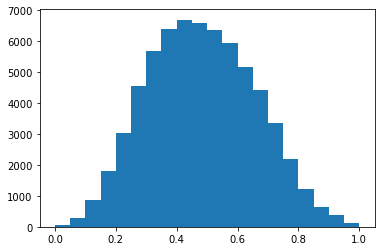

In [5]:
plt.hist(data["responses"].numpy(), bins=20)
plt.show()

## Modeling in pyroed

Specify the design space via SCHEMA, CONSTRAINTS, FEATURE_BLOCKS, and GIBBS_BLOCKS.

In [6]:
SCHEMA = OrderedDict()
for n in range(8):
    SCHEMA[f"Nucleotide{n}"] = ["A", "C", "G", "T"]

CONSTRAINTS = []  # No constraints.

singletons = [[name] for name in SCHEMA]
pairs = [list(ns) for ns in zip(SCHEMA, list(SCHEMA)[1:])]
triples = [list(ns) for ns in zip(SCHEMA, list(SCHEMA)[1:], list(SCHEMA)[2:])]

FEATURE_BLOCKS = singletons + pairs
GIBBS_BLOCKS = triples

Let's start with a random subsample of data.

In [7]:
pyro.set_rng_seed(0)
full_size = len(data["responses"])
batch_size = 10
ids = torch.randperm(full_size)[:batch_size]
experiment = {k: v[ids] for k, v in data.items()}
print(f"Best response = {experiment['responses'].max():0.6g}")

Best response = 0.574323


Each step of the OED process we'll test on new data. Let's make a helper to simulate lab work.

In [8]:
seq_to_id = {tuple(row): i for i, row in enumerate(data["sequences"].tolist())}

def update_experiment(experiment: dict, design: set) -> dict:
    batch_ids = experiment["batch_ids"].max().item() + 1
    ids = list(map(seq_to_id.__getitem__, sorted(design)))
    new_data = {
        "sequences": data["sequences"][ids],
        "batch_ids": torch.full((len(ids),), batch_ids),
        "responses": data["responses"][ids],
    }
    experiment = {k: torch.cat([v, new_data[k]]) for k, v in experiment.items()}
    print(f"Best response = {experiment['responses'].max():0.6g}")
    return experiment

def make_design(experiment: dict) -> set:
    return thompson_sample(
        SCHEMA,
        CONSTRAINTS,
        FEATURE_BLOCKS,
        GIBBS_BLOCKS,
        experiment,
        inference="svi",
        svi_num_steps=201,
        sa_num_steps=201,
        log_every=0,
        jit_compile=False,
    )

Initialize our sequence of experiments:

In [9]:
experiments = [experiment]

Let's start with a single loop of active learning:

In [10]:
%%time
design = make_design(experiments[-1])
print("Design:")
pprint(design)
experiments.append(update_experiment(experiments[-1], design))

Design:
{(0, 2, 3, 3, 1, 2, 1, 1),
 (0, 3, 0, 2, 0, 1, 3, 1),
 (1, 0, 3, 1, 0, 1, 0, 0),
 (1, 0, 3, 3, 3, 3, 1, 0),
 (1, 3, 0, 2, 0, 0, 3, 0),
 (2, 1, 1, 0, 2, 3, 2, 1),
 (2, 1, 3, 1, 3, 3, 3, 1),
 (2, 2, 0, 0, 2, 3, 1, 1),
 (3, 1, 3, 0, 0, 0, 3, 0),
 (3, 3, 3, 0, 0, 2, 3, 1)}
Best response = 0.905897
CPU times: user 4.91 s, sys: 17.3 ms, total: 4.93 s
Wall time: 4.93 s


Let's run multiple loops, say 10 more loops.

In [11]:
%%time
for step in range(10):
    design = make_design(experiments[-1])
    experiments.append(update_experiment(experiments[-1], design))

Best response = 0.905897
Best response = 0.905897
Best response = 0.905897
Best response = 0.94027
Best response = 0.94027
Best response = 0.959295
Best response = 0.959295
Best response = 0.959295
Best response = 0.959295
Best response = 0.959295
CPU times: user 53.3 s, sys: 175 ms, total: 53.4 s
Wall time: 53.5 s


How did the response improve over time?

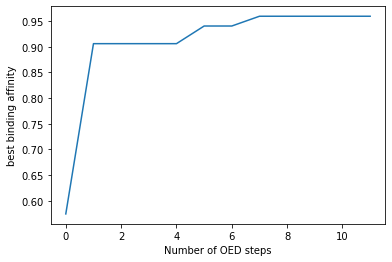

In [13]:
responses = [e["responses"].max().item() for e in experiments]
plt.plot(responses)
plt.xlabel("Number of OED steps")
plt.ylabel("best binding affinity");